### Import Libraries & Set Global Vars

In [1]:
import pandas as pd
import numpy as np

In [669]:
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_columns', None)

In [747]:
#Colors used in charts throughout
stripe_grey = '#8898a7'
stripe_blue = '#7b94f2'
stripe_lightblue = '#4fb1e4'
stripe_green = '#49ce91'
stripe_yellow = '#f2be65'
stripe_orange = '#f39b62'
stripe_red = '#f6765f'
stripe_pink = '#d482d5'
stripe_purple = '#a78be4'

## Ingest Data

Ingest both data sources in & do some basic data processing

### Payments Data

In [860]:
df = pd.read_csv('Data/dstakehome_payments.csv')
df_payments = df[:]

In [861]:
#Change column types
df_payments['merchant'] = df_payments['merchant'].astype(str)
df_payments['date'] = pd.to_datetime(df_payments['date'])

# Get min and max dates for week calculations

trans_start_date = min(df_payments.date)
trans_end_date = max(df_payments.date)

In [862]:
# Add weekday
df_payments['weekday'] = df_payments['date'].dt.day_name()


custom_start_date = min(df_payments.date)
custom_end_date = max(df_payments.date)

df_payments['week_number'] = ((df_payments['date'] - trans_start_date).dt.days // 7) + 1
df_payments['month_number'] = ((df_payments['date'].dt.year - trans_start_date.year) * 12 + df_payments['date'].dt.month - trans_start_date.month) + 1


# Add month name
df_payments['month'] = df_payments['date'].dt.month_name()



In [863]:

# Convert cents to dollars
columns_to_divide = ['total_volume', 'subscription_volume', 'checkout_volume', 'payment_link_volume']

df_payments[columns_to_divide] = df_payments[columns_to_divide].apply(lambda x: x / 100)

#Add in other volume to account for unaccounted dollars
df_payments['other_volume'] = df_payments.total_volume\
    - df_payments.subscription_volume - df_payments.checkout_volume - df_payments.payment_link_volume

#### Create Payment Summary Tables

In [8]:
#Calculate week level metrics
#Didn't end up actually using this for anything

min_week = min(df_payments.week_number)
max_week = max(df_payments.week_number)

df_payments_weekly = df_payments[(df_payments.week_number > min_week) & (df_payments.week_number < max_week)]

df_payments_weekly = df_payments_weekly.groupby(['merchant', 'week_number']).agg({
    'subscription_volume': sum,
    'checkout_volume': sum,
    'payment_link_volume': sum,
    'other_volume': sum,
    'total_volume': sum,
    'weekday': 'count'
}).reset_index()


df_payments_weekly['subscription_volume_pct'] = df_payments_weekly.subscription_volume/df_payments_weekly.total_volume
df_payments_weekly['checkout_volume_pct'] = df_payments_weekly.subscription_volume/df_payments_weekly.total_volume
df_payments_weekly['payment_link_pct'] = df_payments_weekly.subscription_volume/df_payments_weekly.total_volume
df_payments_weekly['other_volume_pct'] = df_payments_weekly.subscription_volume/df_payments_weekly.total_volume

#df_payments_weekly['pct_days_transaction_week'] = df_payments_weekly.weekday/7

### Process Merchant Data & Create Dims

Create a majorirty oif the merchant dim fields we'll be using

#### Load in Data & Change Data Types

In [10]:
df_merchants = pd.read_csv('Data/dstakehome_merchants.csv')

df_merchants['first_charge_date'] = df_merchants['first_charge_date'].replace('0', np.nan)
df_merchants['first_charge_date'] = pd.to_datetime(df_merchants['first_charge_date'])

#### Bring in External Geo Data

In [850]:
#Bring in outside country code data to roll up to region

df_country = pd.read_csv('Data/all_country_codes.csv')
df_country = df_country.rename(columns={'alpha-2': 'country', 'name': 'country_name', 'sub-region': 'sub_region'})

df_country = df_country[['country', 'country_name', 'region', 'sub_region']]

df_country['region'] = \
    np.where(df_country['region'] == 'Americas', df_country['sub_region'], df_country['region'])


#### Get First/Last Dates for Merchants

In [12]:
#Get First Sub Usage
df_merch_sub = df_payments[df_payments.subscription_volume > 0].groupby('merchant').agg({
    'date': 'min'
}).reset_index()

df_merch_sub.rename(columns={'date': 'first_sub_date'}, inplace = True)
df_merch_sub['is_sub'] = 1




In [13]:
#Identify Start of Period for Merchant
df_merch_trans = df_payments.groupby('merchant').agg({
    'date': 'min'
}).reset_index()

df_merch_trans.rename(columns={'date': 'first_trans_date'}, inplace = True)

df_merch_trans = df_merch_trans.merge(df_merchants[['merchant', 'industry', 'first_charge_date']], how = 'left' ,on = 'merchant')

df_merch_trans['period_start_date'] = np.maximum(df_merch_trans.first_charge_date,trans_start_date)


df_merch_trans = df_merch_trans.merge(df_merch_sub, on = 'merchant', how='left')

df_merch_trans['is_sub'] = df_merch_trans.is_sub.fillna(0)

df_merch_trans['days_to_sub_start'] = (df_merch_trans.first_sub_date - df_merch_trans.period_start_date).dt.days




In [14]:
df_industry = df_merch_trans.groupby('industry').agg({
    'is_sub' : sum,
    'merchant' : 'count'
}).reset_index()


df_industry.rename(columns={'merchant': 'merchant_count'})

df_industry['industry_sub_avg_pct'] = df_industry.is_sub/df_industry.merchant

df_industry.drop(['is_sub', 'merchant'], axis=1, inplace = True)

#### Merge all dims back to Merchants Data

In [15]:
df_merchants = df_merchants.merge(df_country, how = 'left', on = 'country')

df_merch_trans.drop(['first_trans_date', 'first_charge_date', 'industry'], axis=1, inplace = True)
df_merchants = df_merchants.merge(df_merch_trans, how = 'left', on = 'merchant')

df_merchants = df_merchants.merge(df_industry, how = 'left', on = 'industry')


#### Merge Payments/Merchant Data

In [16]:
df_payments_full = df_payments.merge(df_merchants, on = 'merchant', how = 'left')

Look at industry subscription average as an alterantive to one hot encoding every single industry value

In [17]:

sum_replace_volume = df_payments_full.groupby('industry').agg({
    'subscription_volume': 'sum',
    'checkout_volume': 'sum',
    'payment_link_volume': 'sum',
    'other_volume': 'sum',
    'total_volume': 'sum'
}).rename(columns=lambda x: x.replace('_volume', '_amount'))

# Count of rows and rename the column to 'total_transactions'
total_transactions = df_payments_full.groupby('industry').size().reset_index(name='total_transactions')

# Unique count of 'merchant'
unique_merchant_count = df_payments_full.groupby('industry')['merchant'].nunique().reset_index(name='unique_merchant')

#Count of sub merchants
unique_merchant_count = df_payments_full.groupby('industry')['merchant'].nunique().reset_index(name='unique_merchant')

unique_merchant_sub_count = df_merchants.groupby('industry').agg({'is_sub': 'sum'}).reset_index()

# Concatenate all summaries
df_industry = pd.concat([sum_replace_volume,\
                         total_transactions.set_index('industry'), \
                         unique_merchant_count.set_index('industry'),\
                         unique_merchant_sub_count.set_index('industry')], axis=1)

df_industry = df_industry.reset_index()

df_industry['merchant_sub_pct'] = df_industry.is_sub/df_industry.unique_merchant

#### Exploratory Data Analysis

Exploratory analysis to see how business volume changes after moving to a subcription model

In [754]:
df_payments_full = df_payments.merge(df_merchants, on = 'merchant', how = 'left')

df_payments_full['is_current_sub'] = df_payments_full.first_sub_date <= df_payments_full.date


In [773]:
df_merchants_sub_convert = df_payments_full[df_payments_full.days_to_sub_start > 45]
df_merchants_sub_convert = df_merchants_sub_convert.groupby(['merchant', 'is_current_sub']).agg({
    'date': [min, max],
    'total_volume' : [sum, 'count'],
}).reset_index()

df_merchants_sub_convert.columns = ['merchant', 'is_current_sub', 'start_date', 'end_date', \
                                    'total_volume', 'transactions']


df_merchants_sub_convert['period_days'] = \
    (df_merchants_sub_convert.end_date - df_merchants_sub_convert.start_date).dt.days +  1

df_merchants_sub_convert['avg_daily_volume'] = \
    df_merchants_sub_convert.total_volume/df_merchants_sub_convert.period_days


df_merchants_sub_convert['avg_transact_days'] = \
    df_merchants_sub_convert.transactions/df_merchants_sub_convert.period_days

In [774]:
df_false = df_merchants_sub_convert[df_merchants_sub_convert.is_current_sub == False]\
    [['merchant', 'avg_daily_volume', 'avg_transact_days']]

df_false.columns = ['merchant', 'avg_daily_volume_presub', 'avg_transact_days_presub']

df_true = df_merchants_sub_convert[df_merchants_sub_convert.is_current_sub == True]\
    [['merchant', 'avg_daily_volume', 'avg_transact_days']]

df_true.columns = ['merchant', 'avg_daily_volume_postsub',  'avg_transact_days_postsub']

df_sub_analysis = df_true.merge(df_false, how='inner', on='merchant')

In [793]:
df_sub_analysis['volume_delta'] = \
    (df_sub_analysis.avg_daily_volume_postsub - df_sub_analysis.avg_daily_volume_presub)
df_sub_analysis['volume_pct_delta'] = \
    (df_sub_analysis.avg_daily_volume_postsub/df_sub_analysis.avg_daily_volume_presub) - 1

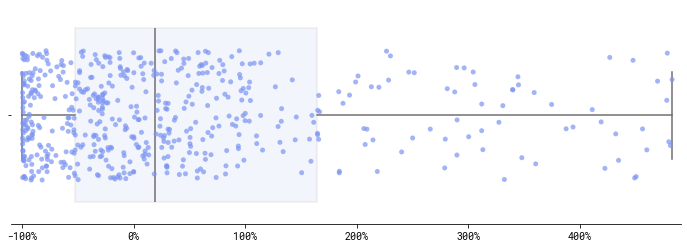

In [819]:
#Plot spread of change as a %

plt.rcParams["figure.figsize"] = (12,4)

# Create a boxplot with jittered points using seaborn
sns.boxplot(x='volume_pct_delta', data=df_sub_analysis,\
            boxprops=dict(alpha=0.1),  color = stripe_blue) # To make outliers visible
sns.stripplot(x='volume_pct_delta', data=df_sub_analysis,  alpha=0.7, jitter=.3, color = stripe_blue)

# Add labels and title
plt.xlabel('')
plt.ylabel('')

# Calculate the 25th and 75th percentiles (Q1 and Q3)
Q1 = df_sub_analysis['volume_pct_delta'].quantile(0.25)
Q3 = df_sub_analysis['volume_pct_delta'].quantile(0.75)


# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = -1.1
upper_bound = Q3 + 1.5 * IQR

# Set the x-axis limits based on the bounds
plt.xlim(lower_bound, upper_bound)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Show the plot
plt.show()

## Filter Data

In [539]:
dataset_min_date = min(df_payments.date)
dataset_max_date = max(df_payments.date)

In [540]:
df_payments_full = df_payments.merge(df_merchants, on = 'merchant', how = 'left')

df_payments_full['is_current_sub'] = df_payments_full.first_sub_date <= df_payments_full.date

We primarily care about non-sub merchants and merchants that didn't convert to subscriptions quickly

In [541]:
df_payments_filtered = df_payments_full[(df_payments_full.is_sub == 0 ) |\
                 ((df_payments_full.days_to_sub_start > 45) & (df_payments_full.is_current_sub == False))]

### Create Transaction Data Features

#### Gini Index

Use Gini as a measure of uniformity as standard deviation can't be used due to non-normality

In [542]:


def gini_index(x):
    sorted_x = np.sort(x)
    n = len(sorted_x)
    cumsum = np.cumsum(sorted_x)
    total = np.sum(sorted_x)
    if total == 0:  # Handle division by zero
        return np.nan
    gini = 1 - 2 * (np.sum((n - np.arange(1, n + 1)) * sorted_x) / (n * total))
    return gini

In [543]:
df_gini_overall = df_payments_filtered\
    .groupby('merchant')[[ 'total_volume']]\
        .apply(lambda x: x.apply(gini_index)).reset_index()


# Rename columns for clarity
df_gini_overall.columns = ['merchant', 'total_volume_gini']


#### Weekday Transaction %

We Look at weekly trasnactions to see if its a 7 day/week business

In [864]:

min_week = min(df_payments.week_number)
max_week = max(df_payments.week_number)

#Remove Partial Weeks
df_payments_weekly = df_payments[(df_payments.week_number > min_week) & (df_payments.week_number < max_week)]

df_payments_weekly = df_payments_weekly.groupby(['merchant', 'week_number']).agg({
    'weekday': 'count'
}).reset_index()

df_payments_weekly['pct_days_transaction_week'] = df_payments_weekly.weekday/7

df_payments_weekly = df_payments_weekly.groupby(['merchant']).agg({'pct_days_transaction_week': 'mean'}).reset_index()

#### Calculate (Almost) All Continuous Metrics

In [546]:
df_merchant_summary= df_payments_filtered.groupby('merchant').agg({
    'date': [min, max],
    'first_charge_date':  max,
    'checkout_volume': sum,
    'payment_link_volume': sum,
    'other_volume': sum,
    'total_volume': sum,
    'merchant': 'count',
    'is_sub': max
}).reset_index()

df_merchant_summary.columns = ['merchant', 'first_trans_date', 'last_trans_date', 'first_charge_date', \
                              'checkout_volume', 'payment_link_volume', 'other_volume', 'total_volume', \
                              'transactions', 'is_sub']



df_merchant_summary['period_start_date'] = np.maximum(df_merchant_summary.first_charge_date, dataset_min_date)

df_merchant_summary['period_end_date'] = np.where(df_merchant_summary.is_sub == 1,\
                                                   df_merchant_summary.last_trans_date,
                                                   dataset_max_date)


df_merchant_summary['merchant_period_days'] = \
    (df_merchant_summary.period_end_date - df_merchant_summary.period_start_date).dt.days + 1

df_merchant_summary['total_volume_daily_avg'] = \
        df_merchant_summary.total_volume/df_merchant_summary.merchant_period_days

df_merchant_summary['transaction_pct_days'] = \
        df_merchant_summary.transactions/df_merchant_summary.merchant_period_days

df_merchant_summary['checkout_volume_pct'] = df_merchant_summary.checkout_volume/df_merchant_summary.total_volume
df_merchant_summary['payment_link_volume_pct'] = df_merchant_summary.payment_link_volume/df_merchant_summary.total_volume
df_merchant_summary['other_volume_pct'] = df_merchant_summary.other_volume/df_merchant_summary.total_volume

df_merchant_summary = df_merchant_summary.merge(df_gini_overall, on = 'merchant', how = 'left')
df_merchant_summary = df_merchant_summary.merge(df_payments_weekly, on = 'merchant', how = 'left')

df_merchant_summary = df_merchant_summary[(df_merchant_summary.total_volume > 99) \
                    & (df_merchant_summary.transactions > 4)]

## Modeling

In [822]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score,\
f1_score, precision_recall_curve, auc
from sklearn.model_selection import GridSearchCV


### Prep &Train/Test Split

In [836]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [837]:
df_model = df_merchant_summary.merge(df_merchants[['merchant', \
                                                   'region', 'business_size', 'industry_sub_avg_pct']],\
                                     on = 'merchant',
                                    how = 'left')




In [838]:
# Select relevant columns from the DataFrame
df_model = df_model[['merchant', 'total_volume_daily_avg',
                                'checkout_volume_pct', 'payment_link_volume_pct',
                                'other_volume_pct', 'transaction_pct_days', \
                                 'total_volume_gini', 'pct_days_transaction_week',\
                                 'industry_sub_avg_pct', \
                                'region', 'business_size',\
                                'is_sub']]

df_model['is_sub'] = df_model.is_sub.astype(int)

df_model['pct_days_transaction_week'].fillna(0, inplace=True)

# Split data into features (X) and target variable (y)
X = df_model.drop(columns=['merchant', 'is_sub'])  # Features
y = df_model['is_sub']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Positive Class has proportion " + str(sum(y)/len(y)))


Positive Class has proportion 0.03172928669966729


In [842]:
# Define categorical features
categorical_features = ['region', 'business_size']

# Define numerical features
numerical_features = ['total_volume_daily_avg',
                    'checkout_volume_pct', 'payment_link_volume_pct', 'other_volume_pct',\
                       'total_volume_gini', 'pct_days_transaction_week',
                    'transaction_pct_days', \
                    'industry_sub_avg_pct']

# Create preprocessor for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),  # passthrough numerical features
        ('cat', OneHotEncoder(), categorical_features)  # one-hot encode categorical features
    ])


#### Simple Logistic Regression (Baseline)

In [827]:
# Create Logistic Regression classifier pipeline with default parameters
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),  # Add StandardScaler for feature scaling
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced'))
])

# Fit the pipeline to the training data
lr_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = lr_pipeline.predict(X_test)

# Evaluate the model
roc_auc = roc_auc_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("ROC-AUC Score:", roc_auc)
print("PR-AUC:", pr_auc)
print("F1-score:", f1score)

print("\nClassification Report:")
print(class_report)

conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

ROC-AUC Score: 0.6180672268907563
PR-AUC: 0.31351682607693726
F1-score: 0.10609480812641081

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.68      0.80      2380
           1       0.06      0.55      0.11        85

    accuracy                           0.68      2465
   macro avg       0.52      0.62      0.46      2465
weighted avg       0.95      0.68      0.78      2465

Confusion Matrix:
[[1626  754]
 [  38   47]]


#### Logistic Ridge with L2 Regularization

Attempt to use L2 regularization to deal with correlated variables

In [828]:
# Create Logistic Regression classifier pipeline with Ridge regularization
ridge_lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),  # Add StandardScaler for feature scaling
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced', penalty='l2'))  # Ridge regularization
])

param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]  # Values of C to try
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(ridge_lr_pipeline, param_grid=param_grid, cv=10, scoring='average_precision')

# Fit the randomized search to the training data
random_search.fit(X_train, y_train)

# Get the best model
best_model = random_search.best_estimator_

# Predict on the test set using the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
roc_auc = roc_auc_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("ROC-AUC Score:", roc_auc)
print("PR-AUC:", pr_auc)
print("F1-score:", f1score)
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
ROC-AUC Score: 0.6510504201680672
PR-AUC: 0.33541676494174255
F1-score: 0.12254901960784313

Confusion Matrix:
[[1699  681]
 [  35   50]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.71      0.83      2380
           1       0.07      0.59      0.12        85

    accuracy                           0.71      2465
   macro avg       0.52      0.65      0.47      2465
weighted avg       0.95      0.71      0.80      2465



#### Baseline Decision Tree

In [829]:
from sklearn.tree import DecisionTreeClassifier


In [844]:
# Create Decision Tree classifier pipeline with default parameters
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

# Fit the pipeline to the training data
dt_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = dt_pipeline.predict(X_test)

# Evaluate the model
roc_auc = roc_auc_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("ROC-AUC Score:", roc_auc)
print("PR-AUC:", pr_auc)
print("F1-score:", f1score)
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

ROC-AUC Score: 0.5176470588235293
PR-AUC: 0.08465179175118323
F1-score: 0.06857142857142856
Confusion Matrix:
[[2296   84]
 [  79    6]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2380
           1       0.07      0.07      0.07        85

    accuracy                           0.93      2465
   macro avg       0.52      0.52      0.52      2465
weighted avg       0.94      0.93      0.93      2465



#### Tuned Decision Tree

In [846]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

# Define the pipeline with preprocessing and Decision Tree classifier
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Define the parameter distribution to sample from
param_dist = {
    'classifier__max_depth': [None] + list(randint(1, 6).rvs(10)),  # Depth of the tree
    'classifier__min_samples_split': randint(2, 11),  # Minimum samples required to split an internal node
    'classifier__min_samples_leaf': randint(1, 5),    # Minimum samples required at each leaf node
    'classifier__class_weight': [None, 'balanced']   # Weights to balance classes
}

# Define the F1 scorer
f1_scorer = make_scorer(f1_score)

# Define the scoring dictionary
scoring = {'F1': f1_scorer}  # You can add more metrics if needed


# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(dt_pipeline, param_distributions=param_dist, n_iter=30, cv=5, \
                                   scoring='f1', refit=True, verbose=1, random_state=42)

# Fit the randomized search to the training data
random_search.fit(X_train, y_train)

# Get the best model
best_model = random_search.best_estimator_


# Predict on the test set using the best model
y_pred = best_model.predict(X_test)


# Evaluate the model
roc_auc = roc_auc_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("ROC-AUC Score:", roc_auc)
print("PR-AUC:", pr_auc)
print("F1-score:", f1score)
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)



Fitting 5 folds for each of 30 candidates, totalling 150 fits
ROC-AUC Score: 0.6508403361344538
PR-AUC: 0.33537004400403464
F1-score: 0.12239902080783356
Confusion Matrix:
[[1698  682]
 [  35   50]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.71      0.83      2380
           1       0.07      0.59      0.12        85

    accuracy                           0.71      2465
   macro avg       0.52      0.65      0.47      2465
weighted avg       0.95      0.71      0.80      2465



C:\Users\saurabh.rane\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


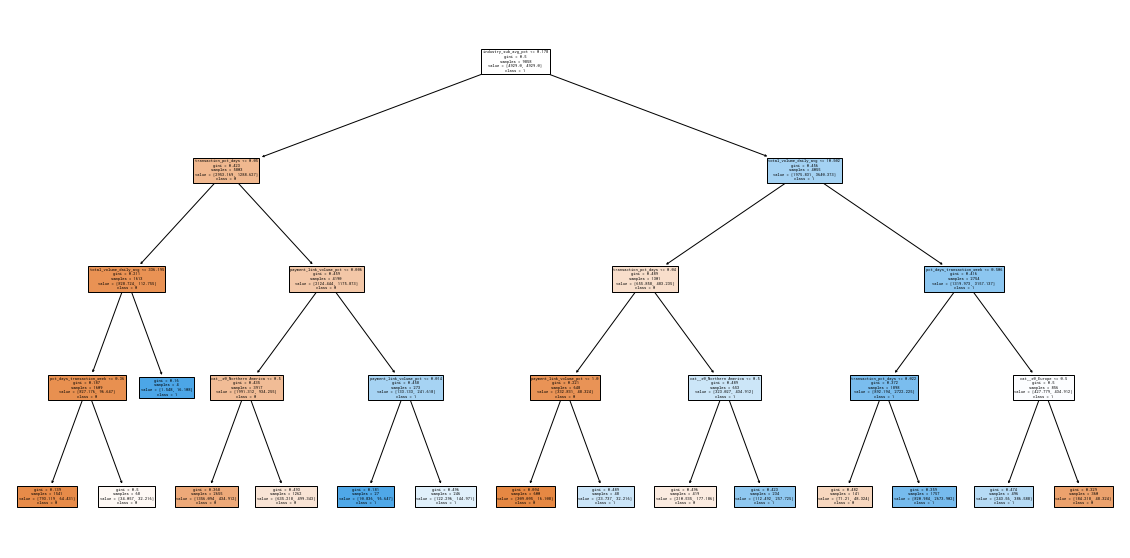

In [847]:
plt.figure(figsize=(20,10))
plot_tree(best_model.named_steps['classifier'],\
          feature_names= dt_pipeline.named_steps["preprocessor"].get_feature_names(), \
          class_names=['0', '1'], filled=True)
plt.show()

#### Baseline Random Forest

In [855]:
# Create Random Forest classifier pipeline with default parameters
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Fit the pipeline to the training data
rf_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_pipeline.predict(X_test)

# Evaluate the model
roc_auc = roc_auc_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("ROC-AUC Score:", roc_auc)
print("PR-AUC:", pr_auc)
print("F1-score:", f1score)
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)



ROC-AUC Score: 0.5
PR-AUC: 0.5172413793103449
F1-score: 0.0
Confusion Matrix:
[[2380    0]
 [  85    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2380
           1       0.00      0.00      0.00        85

    accuracy                           0.97      2465
   macro avg       0.48      0.50      0.49      2465
weighted avg       0.93      0.97      0.95      2465



C:\Users\saurabh.rane\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saurabh.rane\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saurabh.rane\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

#### Hyperparameter Tuning

In [856]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [857]:


# Define hyperparameter grid
param_grid = {
    'classifier__n_estimators': randint(50, 200),  # Number of trees in the forest
    'classifier__max_depth': randint(5, 20),  # Maximum depth of the trees
    'classifier__min_samples_split': randint(2, 10),  # Minimum number of samples required to split a node
    'classifier__min_samples_leaf': randint(1, 5)  # Minimum number of samples required at each leaf node
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(rf_pipeline, param_distributions=param_grid, n_iter=30,\
                                   cv=5, scoring='average_precision', random_state=42)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

# Get the best estimator from the search
best_rf_pipeline = random_search.best_estimator_

# Predict on the test set using the best estimator
y_pred = best_rf_pipeline.predict(X_test)

# Evaluate the model
roc_auc = roc_auc_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)

print("Best Hyperparameters:", random_search.best_params_)


Best Hyperparameters: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 71}


In [858]:
# Create Random Forest classifier pipeline with optimal hyperparameters
params = {key.split('classifier__')[1]: value for key, value in random_search.best_params_.items()}

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced', **params))
])


# Fit the pipeline to the training data
rf_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_pipeline.predict(X_test)


In [859]:
# Evaluate the model
roc_auc = roc_auc_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("ROC-AUC Score:", roc_auc)
print("PR-AUC:", pr_auc)
print("F1-score:", f1score)
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


ROC-AUC Score: 0.6584033613445378
PR-AUC: 0.3274755670293195
F1-score: 0.1327800829875519
Confusion Matrix:
[[1790  590]
 [  37   48]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.75      0.85      2380
           1       0.08      0.56      0.13        85

    accuracy                           0.75      2465
   macro avg       0.53      0.66      0.49      2465
weighted avg       0.95      0.75      0.83      2465



#### Feature Importance

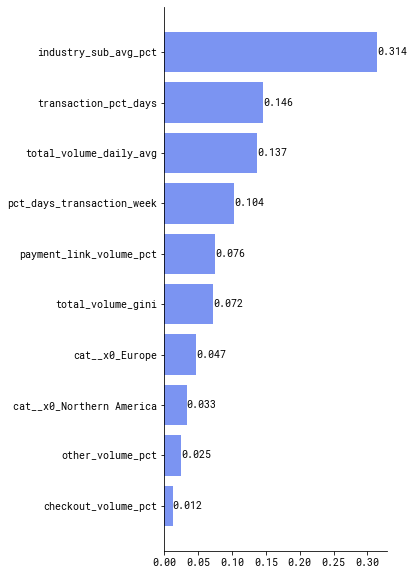

In [648]:
feature_importance = pd.DataFrame({'feature': rf_pipeline.named_steps["preprocessor"].get_feature_names(),\
              'feature_importance': rf_pipeline.named_steps['classifier'].feature_importances_})

feature_importance = feature_importance.sort_values(by='feature_importance', ascending = False)

feature_importance = feature_importance.head(10)


plt.rcParams["figure.figsize"] = (4,10)

bars = plt.barh(feature_importance['feature'], feature_importance['feature_importance'], align='center',\
                color = stripe_blue)

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.3f}', va='center')


plt.gca().invert_yaxis() 
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

plt.show()

#### Class Summaries

In [651]:
import pandas as pd

# Create a DataFrame to store the test set with predicted labels and probabilities
df_test = pd.DataFrame(X_test, columns=X_test.columns)  # Create DataFrame from X_test
df_test['actual_label'] = y_test
df_test['predicted_label'] = y_pred

# Calculate the average of all features for each class
class_averages = {}

# Iterate over each class (0: negative class, 1: positive class)
for label in [1]:
    # Select instances belonging to the class (True Positives, True Negatives, False Positives, False Negatives)
    true_positives = df_test[(df_test['actual_label'] == 1) & (df_test['predicted_label'] == 1)]
    true_negatives = df_test[(df_test['actual_label'] == 0) & (df_test['predicted_label'] == 0)]
    false_positives = df_test[(df_test['actual_label'] == 0) & (df_test['predicted_label'] == 1)]
    false_negatives = df_test[(df_test['actual_label'] == 1) & (df_test['predicted_label'] == 0)]
    
    # Calculate the average of all features for each type of prediction
    class_averages[label] = {
        'true_positives': true_positives.median(),
        'true_negatives': true_negatives.median(),
        'false_positives': false_positives.median(),
        'false_negatives': false_negatives.median()
    }

# Display the average of all features for each class and prediction type
for label, averages in class_averages.items():
    print(f'Class {label} (Median Values): ')
    for prediction_type, avg_features in averages.items():
        print('\n')
        print(f'{prediction_type}:')
        print(avg_features)
    print()

Class 1 (Median Values): 


true_positives:
total_volume_daily_avg      48.14
checkout_volume_pct          0.00
payment_link_volume_pct      0.00
other_volume_pct             1.00
transaction_pct_days         0.16
total_volume_gini            0.50
pct_days_transaction_week    0.26
industry_sub_avg_pct         0.28
actual_label                 1.00
predicted_label              1.00
dtype: float64


true_negatives:
total_volume_daily_avg      19.43
checkout_volume_pct          0.00
payment_link_volume_pct      0.00
other_volume_pct             1.00
transaction_pct_days         0.11
total_volume_gini            0.43
pct_days_transaction_week    0.27
industry_sub_avg_pct         0.08
actual_label                 0.00
predicted_label              0.00
dtype: float64


false_positives:
total_volume_daily_avg      53.27
checkout_volume_pct          0.00
payment_link_volume_pct      0.00
other_volume_pct             1.00
transaction_pct_days         0.16
total_volume_gini            0.48
pct_d

C:\Users\saurabh.rane\AppData\Local\Temp\ipykernel_2264\728105454.py:21: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  'true_positives': true_positives.median(),
C:\Users\saurabh.rane\AppData\Local\Temp\ipykernel_2264\728105454.py:22: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  'true_negatives': true_negatives.median(),
C:\Users\saurabh.rane\AppData\Local\Temp\ipykernel_2264\728105454.py:23: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In a

#### Model Output

In [730]:
df_model = df_merchant_summary.merge(df_merchants[['merchant', \
                                                   'region', 'business_size', 'industry_sub_avg_pct']],\
                                     on = 'merchant',
                                    how = 'left')


# Select relevant columns from the DataFrame
df_model = df_model[['merchant', 'total_volume_daily_avg',
                                'checkout_volume_pct', 'payment_link_volume_pct',
                                'other_volume_pct', 'transaction_pct_days', \
                                 'total_volume_gini', 'pct_days_transaction_week',\
                                 'industry_sub_avg_pct', \
                                'region', 'business_size',\
                                'is_sub']]

df_model['is_sub'] = df_model.is_sub.astype(int)

df_model['pct_days_transaction_week'].fillna(0, inplace=True)

df_model = df_model[df_model.is_sub == 0]

X = df_model.drop(columns=['merchant', 'is_sub'])

output_prob = rf_pipeline.predict_proba(X)[:, 1]

model_output = pd.DataFrame({'merchant': df_model.merchant,\
              'sub_prob': output_prob,
                'total_volume_daily_avg': df_model.total_volume_daily_avg,
                'transaction_pct_days': df_model.transaction_pct_days,
                'pct_days_transaction_week': df_model.pct_days_transaction_week,
                'payment_link_volume_pct': df_model.payment_link_volume_pct,
                'total_volume_gini': df_model.total_volume_gini})

model_output = model_output.merge(df_merchants[['merchant','industry']], on = 'merchant', how='left')

model_output = model_output.merge(df_merchant_summary[['merchant', 'total_volume', 'transactions']],\
                                  on = 'merchant', how='left')




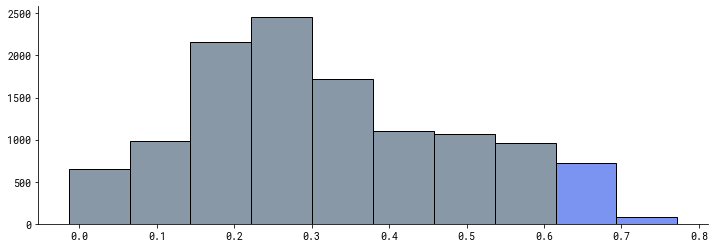

In [731]:
#Get Spread of subscription predicted values

plt.rcParams["figure.figsize"] = (12,4)
num_bins = 10
hist, bins = np.histogram(model_output.sub_prob, bins=num_bins)

colors = [stripe_grey] * (num_bins - 2) + [stripe_blue] * 2
plt.bar(bins[:-1], hist, color=colors, edgecolor='black', width=np.diff(bins))



plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Displaying the plot
plt.show()

In [736]:

model_output_top_merchants = model_output[model_output['sub_prob'] >= model_output['sub_prob'].quantile(0.95)]

model_output_top_merchants = model_output_top_merchants.sort_values(by='total_volume', ascending=False)

model_output_top_merchants.to_csv('model_output_top_merchants.csv')

In [746]:
# Define the selected industries
selected_industries = ['Business services', 'Education', 'Personal services', 'Software']

# Filter the DataFrame for the specified industries
filtered_df = model_output_top_merchants[model_output_top_merchants['industry'].isin(selected_industries)]

# Define a function to get the top n rows for each group
def get_top_n_rows(group, n=10):
    return group.nlargest(n, 'total_volume')

# Apply the function to each group of industries
(filtered_df.groupby('industry', group_keys=False).apply(get_top_n_rows, n=10))\
    .to_csv('model_output_top_indsutries.csv')


### Visualizations

In [82]:
import matplotlib.ticker as mtick


#### % of Merchants with Sub

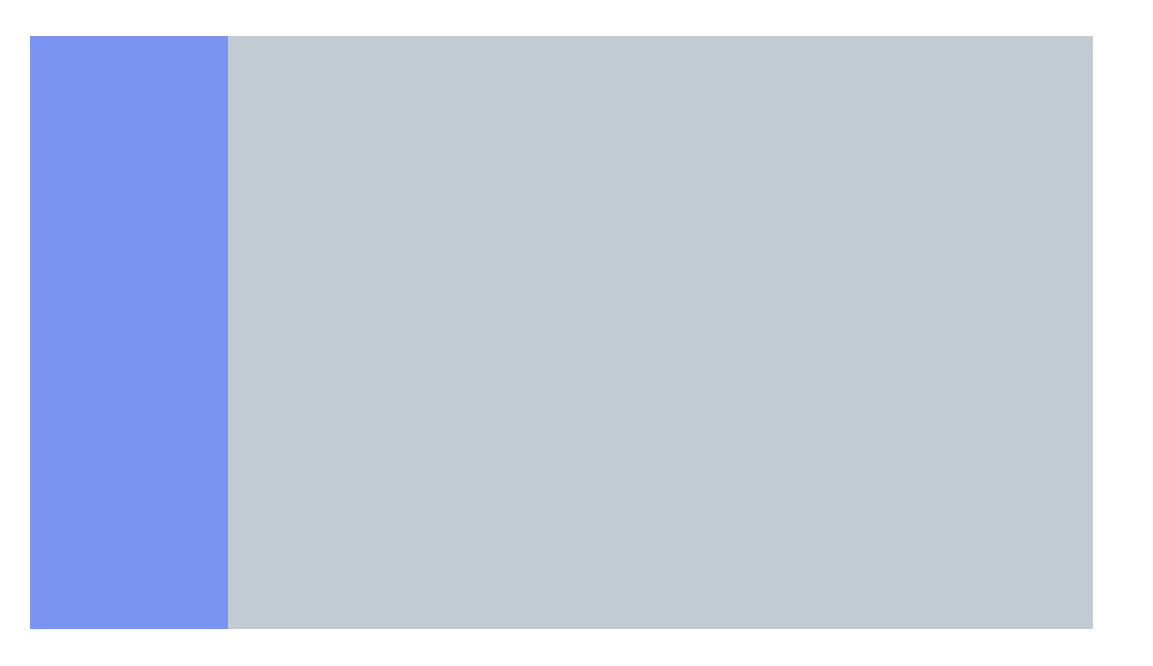

In [96]:


plt.rcParams["figure.figsize"] = (20,12)


unique_count_merchant = df_merchants['merchant'].nunique()
sum_is_sub = df_merchants['is_sub'].dropna().sum()

percent_is_sub = (sum_is_sub / unique_count_merchant) 

fig, ax = plt.subplots()
ax.barh('test', 1, color=stripe_grey, label='Total', alpha = 0.5)
ax.barh('test', percent_is_sub, color=stripe_blue, label='Subscribed')



plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)


plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'


plt.gca().set_xticks([])
plt.gca().set_xticklabels([])
plt.gca().set_yticks([])
plt.gca().set_yticklabels([])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0)) 
plt.ylabel(' ', fontname='Roboto Mono', fontsize=20)

plt.show()

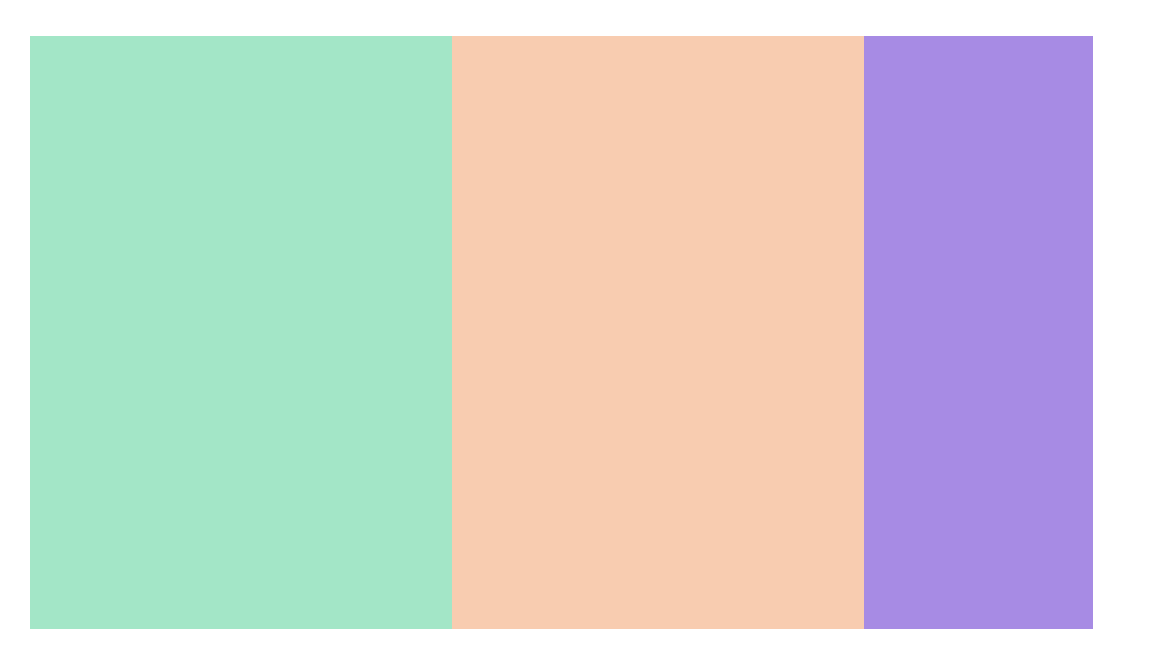

In [117]:
total_subs = df_merchants['is_sub'].dropna().sum()

instant_subs = (df_merchants[df_merchants.days_to_sub_start == 0].is_sub.dropna().sum())/total_subs

quick_sub_converts = (df_merchants[(df_merchants.days_to_sub_start > 0) &  (df_merchants.days_to_sub_start < 46)]\
    .is_sub.dropna().sum())/total_subs

late_sub_converts = (df_merchants[df_merchants.days_to_sub_start > 45]\
    .is_sub.dropna().sum())/total_subs

fig, ax = plt.subplots()
bars1 = ax.barh(['Total'], [instant_subs], color=stripe_green, label='Instant Subs', alpha = 0.5)
bars2 = ax.barh(['Total'], [quick_sub_converts], left=instant_subs, color=stripe_orange, label='Quick Sub Converts'\
                , alpha = 0.5)
bars3 = ax.barh(['Total'], [late_sub_converts], left=instant_subs+quick_sub_converts, color=stripe_purple,\
                label='Late Sub Converts')



plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)


plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'


plt.gca().set_xticks([])
plt.gca().set_xticklabels([])
plt.gca().set_yticks([])
plt.gca().set_yticklabels([])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0)) 
plt.ylabel(' ', fontname='Roboto Mono', fontsize=20)

plt.show()

#### Weekday Data

In [349]:
# 1bdb6fcc  vs e1fc7741
#Week Level

df_weekly_viz = df_payments_filtered.groupby(['merchant', 'weekday']).agg({
    'total_volume': sum
}).reset_index()


In [355]:
df_model[(df_model.merchant == '1bdb6fcc') | (df_model.merchant == 'e1fc7741')]

merchant          first_trans_date           last_trans_date  \
1328   1bdb6fcc 2041-05-03 00:00:00+00:00 2042-06-22 00:00:00+00:00   
10890  e1fc7741 2041-05-11 00:00:00+00:00 2041-07-01 00:00:00+00:00   

              first_charge_date  checkout_volume  payment_link_volume  \
1328  2038-10-02 00:00:00+00:00             0.00                 0.00   
10890 2038-05-08 00:00:00+00:00             0.00                 0.00   

       other_volume  total_volume  transactions  is_sub  \
1328      190494.55     190494.55           372    0.00   
10890      32000.00      32000.00             9    1.00   

              period_start_date           period_end_date  \
1328  2041-05-01 00:00:00+00:00 2042-06-22 00:00:00+00:00   
10890 2041-05-01 00:00:00+00:00 2041-07-01 00:00:00+00:00   

       merchant_period_days  total_volume_daily_avg  transaction_pct_days  \
1328                    418                  455.73                  0.89   
10890                    62                  516.13                  0.15   

       checkout_volume_pct  payment_link_volume_pct  other_volume_pct  \
1328                  0.00                     0.00              1.00   
10890                 0.00                     0.00              1.00   

       total_volume_gini  pct_days_transaction_week            region  \
1328                0.72                       0.89  Northern America   
10890               0.36                       0.23  Northern America   

      business_size  industry_sub_avg_pct  
1328          small                  0.24  
10890         small                  0.24

C:\Users\saurabh.rane\AppData\Local\Temp\ipykernel_2264\3483908961.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viz_df['total_volume'] = viz_df.total_volume/viz_df.total_volume.sum()
C:\Users\saurabh.rane\AppData\Local\Temp\ipykernel_2264\3483908961.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viz_df['weekday'] = pd.Categorical(viz_df['weekday'], \


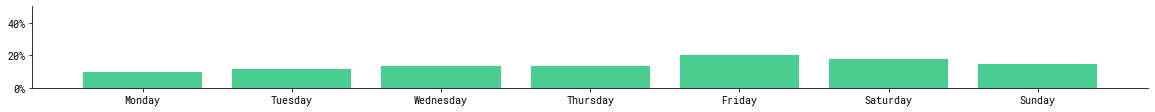

In [350]:
viz_df = df_weekly_viz[(df_weekly_viz.merchant == '1bdb6fcc')]

viz_df['total_volume'] = viz_df.total_volume/viz_df.total_volume.sum()

# Reorder the DataFrame by weekday
viz_df['weekday'] = pd.Categorical(viz_df['weekday'], \
                                   categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
viz_df = viz_df.sort_values('weekday')

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(20, 1.5))

# Plot the data
ax.bar(viz_df['weekday'], viz_df['total_volume'], color=stripe_green)

ax.set_ylim(0, 0.5)


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.rcParams['font.family'] = 'Roboto Mono'

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) 

C:\Users\saurabh.rane\AppData\Local\Temp\ipykernel_2264\2252703878.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viz_df['total_volume'] = viz_df.total_volume/viz_df.total_volume.sum()
C:\Users\saurabh.rane\AppData\Local\Temp\ipykernel_2264\2252703878.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  viz_df = viz_df.append({'weekday': 'Wednesday', 'total_volume': 0}, ignore_index=True)


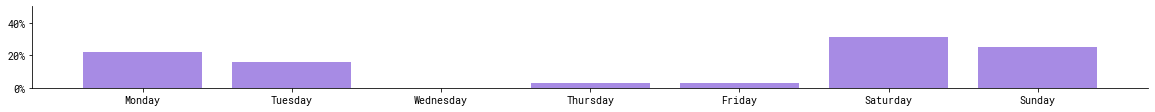

In [354]:
viz_df = df_weekly_viz[(df_weekly_viz.merchant == 'e1fc7741')]

viz_df['total_volume'] = viz_df.total_volume/viz_df.total_volume.sum()
viz_df = viz_df.append({'weekday': 'Wednesday', 'total_volume': 0}, ignore_index=True)

# Reorder the DataFrame by weekday
viz_df['weekday'] = pd.Categorical(viz_df['weekday'], \
                                   categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)


viz_df = viz_df.sort_values('weekday')

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(20, 1.5))


# Plot the data
ax.bar(viz_df['weekday'], viz_df['total_volume'], color=stripe_purple)
ax.set_ylim(0, 0.5)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.rcParams['font.family'] = 'Roboto Mono'

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) 

#### Gini Comparison

In [398]:
df_model[(df_model.merchant == '64964929') | (df_model.merchant == '0d753d5f')]

merchant          first_trans_date           last_trans_date  \
625   0d753d5f 2041-05-01 00:00:00+00:00 2042-06-22 00:00:00+00:00   
4817  64964929 2041-05-01 00:00:00+00:00 2042-06-22 00:00:00+00:00   

             first_charge_date  checkout_volume  payment_link_volume  \
625  2036-08-05 00:00:00+00:00             0.00                 0.00   
4817 2041-04-10 00:00:00+00:00             0.00              3945.25   

      other_volume  total_volume  transactions  is_sub  \
625      192606.20     192606.20           380    0.00   
4817     187434.86     191380.11           275    0.00   

             period_start_date           period_end_date  \
625  2041-05-01 00:00:00+00:00 2042-06-22 00:00:00+00:00   
4817 2041-05-01 00:00:00+00:00 2042-06-22 00:00:00+00:00   

      merchant_period_days  total_volume_daily_avg  transaction_pct_days  \
625                    418                  460.78                  0.91   
4817                   418                  457.85                  0.66   

      checkout_volume_pct  payment_link_volume_pct  other_volume_pct  \
625                  0.00                     0.00              1.00   
4817                 0.00                     0.02              0.98   

      total_volume_gini  pct_days_transaction_week            region  \
625                0.38                       0.91  Northern America   
4817               0.80                       0.66  Northern America   

     business_size  industry_sub_avg_pct  
625          small                  0.24  
4817         small                  0.24

C:\Users\saurabh.rane\AppData\Local\Temp\ipykernel_2264\1797425175.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viz_df['days'] = (viz_df.date - min(viz_df.date)).dt.days


<BarContainer object of 275 artists>

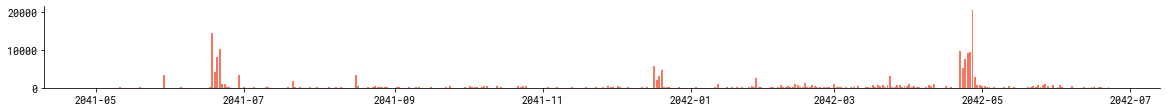

In [399]:
viz_df = df_payments[df_payments.merchant == '64964929']

viz_df['days'] = (viz_df.date - min(viz_df.date)).dt.days

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(20, 1.5))

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Plot the data
ax.bar(viz_df['date'], viz_df['total_volume'], color=stripe_red)


In [405]:
viz_df.total_volume.mean()


695.9276727272728

In [406]:

viz_df.total_volume.std()

2090.4861185504747

C:\Users\saurabh.rane\AppData\Local\Temp\ipykernel_2264\3933901887.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viz_df['days'] = (viz_df.date - min(viz_df.date)).dt.days


<BarContainer object of 380 artists>

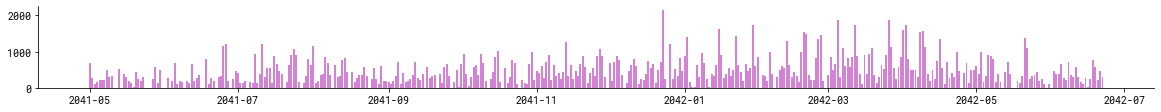

In [395]:
viz_df = df_payments[df_payments.merchant == '0d753d5f']

viz_df['days'] = (viz_df.date - min(viz_df.date)).dt.days

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(20, 1.5))


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Plot the data
ax.bar(viz_df['date'], viz_df['total_volume'], color=stripe_pink)


#### Correlation Plot

C:\Users\saurabh.rane\AppData\Local\Temp\ipykernel_2264\4126278673.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = X.corr()


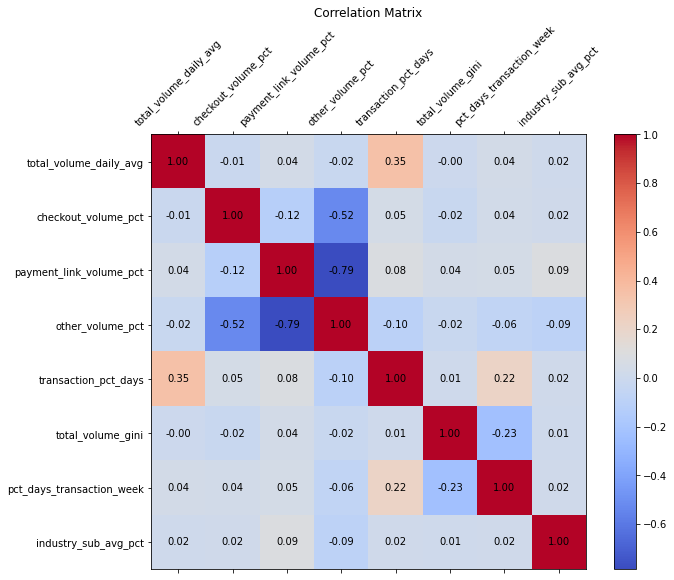

In [210]:
import matplotlib.pyplot as plt

correlation_matrix = X.corr()

fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(correlation_matrix, cmap='coolwarm')

for (i, j), val in np.ndenumerate(correlation_matrix):
    ax.text(j, i, '{:.2f}'.format(val), ha='center', va='center', color='black')

plt.title('Correlation Matrix')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.colorbar(cax)
plt.show()